In [1]:
import pandas as pd
import numpy as np
import os
import torch as tc
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
import random
from vmdpy import VMD


In [2]:
Rossmann_train = pd.read_csv('Baseline_Datasets-forecast/03-Rossman/train.csv',low_memory= False)
Rossmann_test = pd.read_csv('Baseline_Datasets-forecast/03-Rossman/test.csv')
Rossmann_info = pd.read_csv('Baseline_Datasets-forecast/03-Rossman/store.csv')
#display the imported datasets

#display(Rossmann_train)
#display(Rossmann_test)
#display(Rossmann_info)

#we can drop the id column from the test dataset as it is a duplicate of the index
Rossmann_test.drop(columns = 'Id', inplace = True)

In [3]:
#shows number of unique values for each column for each dataset
display(Markdown('### Training (Rossmann_train) dataset unique values'))
print(Rossmann_train.nunique(), '\n\n')
display(Markdown('### Testing (Rossmann_test) dataset unique values'))
print(Rossmann_test.nunique(),'\n\n')
display(Markdown('### Store information (Rossmann_info)  dataset unique values'))
print(Rossmann_info.nunique())



#Open, Promo, School holiday are binary as well as Promo 2
#There are missing values on the field CompetitionDistance for the Rossmann_info dataframe


### Training (Rossmann_train) dataset unique values

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64 




### Testing (Rossmann_test) dataset unique values

Store            856
DayOfWeek          7
Date              48
Open               2
Promo              2
StateHoliday       2
SchoolHoliday      2
dtype: int64 




### Store information (Rossmann_info)  dataset unique values

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64


In [4]:

#if the data has no missing values, the number of stores times the dates should output the dataset lenght
display(Markdown('#### Number of store IDs times Dates for train dataset'))
print(Rossmann_train['Store'].nunique()*Rossmann_train['Date'].nunique())

display(Markdown('#### Number of rows on train dataframe'))
print(len(Rossmann_train))

print('\n\n')

#Separate by store
stores = {}
lengths = []

Rossmann_train['Date'] = pd.to_datetime(Rossmann_train['Date'])
date_range = pd.date_range(start=Rossmann_train['Date'].min(), end=Rossmann_train['Date'].max())
train_full_dates = pd.DataFrame(columns=Rossmann_train.columns).reindex(index=[])
dates_df = pd.DataFrame({'Date': date_range})

for i in (Rossmann_train['Store'].unique()):    
    temp_df = Rossmann_train[Rossmann_train['Store'] == i]
    temp_df = pd.merge(dates_df, temp_df, on='Date', how='left')   
    
    stores [f'store_{i}'] = temp_df
    lengths.append(len(stores[f'store_{i}']))
    
    train_full_dates = pd.concat([train_full_dates, temp_df])
    
#check if all products have the same number of values
for j in range(len(lengths)):
    if lengths[j] == 942:
        pass
    else:
        print(f'wrong value at array position {j}')
        break
    if j == (len(lengths) -1):
        print(f' all missing dates filled for {j+1} stores')
    

##filling missing dates on dataframe

#shifts the original daframe by a year
train_full_dates_shifted = train_full_dates.shift(365)

# Replace NaN values in original dataframe with the shifted values
train_full_dates = train_full_dates.fillna(train_full_dates_shifted)

## check to see if all was resplaced

# Create a boolean mask indicating the locations of the NaN values
mask = train_full_dates.isna()

# Replace the True values in the mask with the corresponding row and column indices
nan_positions = np.where(mask)

# Print the positions of the NaN values
for i, j in zip(*nan_positions):
    print(f"NaN value found at position ({i}, {j})")
    

#### Number of store IDs times Dates for train dataset

1050330


#### Number of rows on train dataframe

1017209



 all missing dates filled for 1115 stores


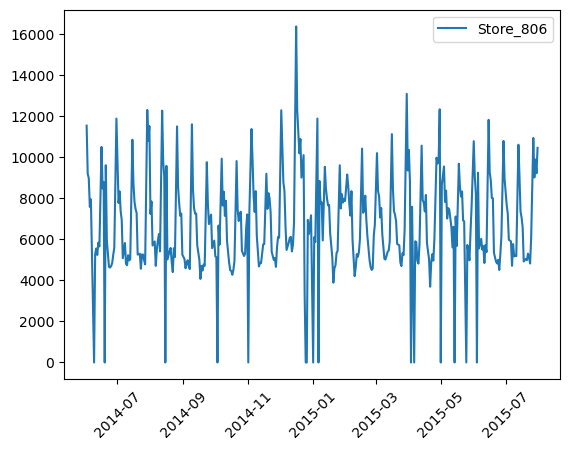

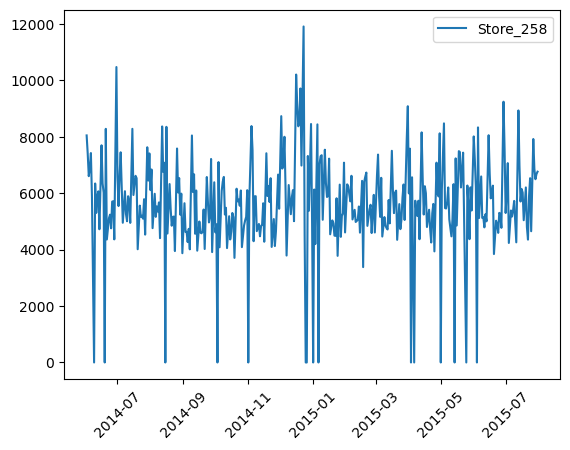

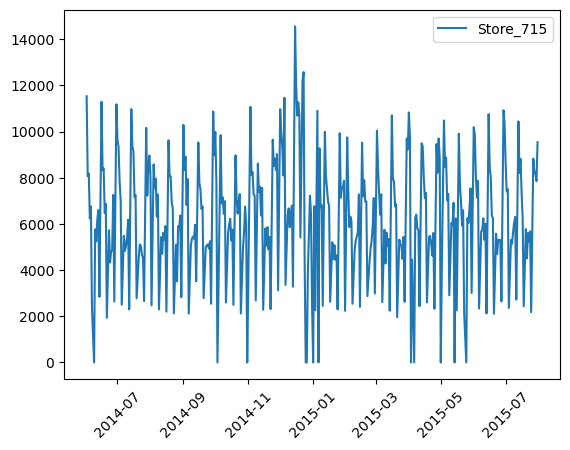

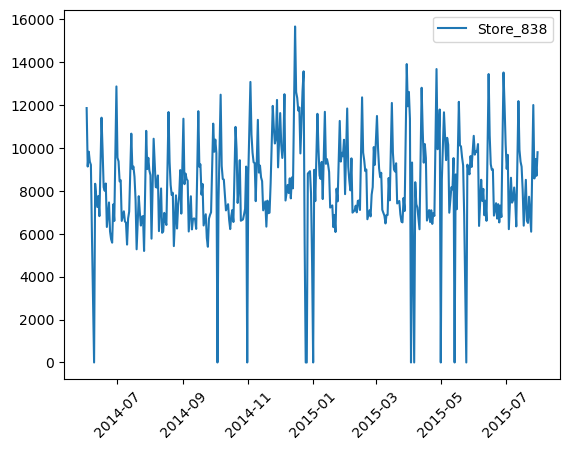

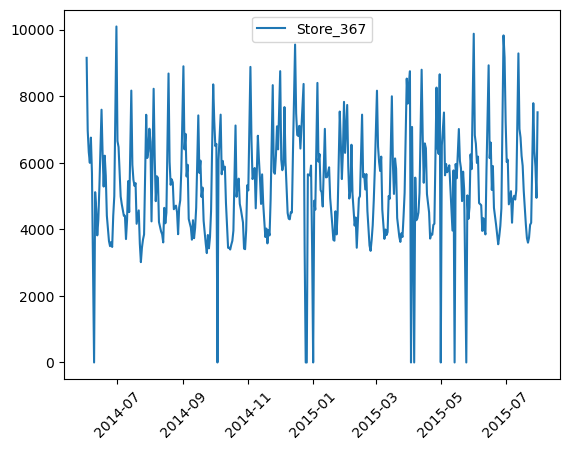

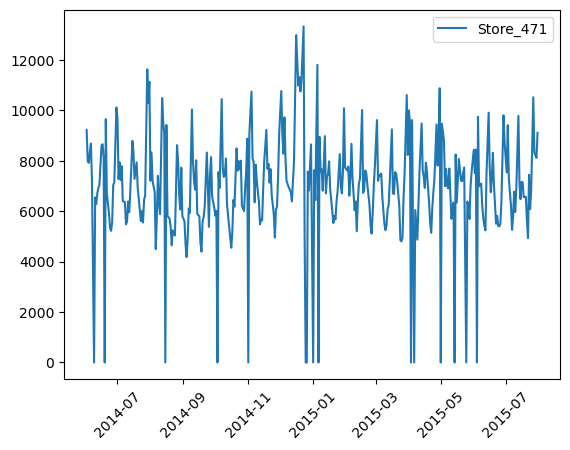

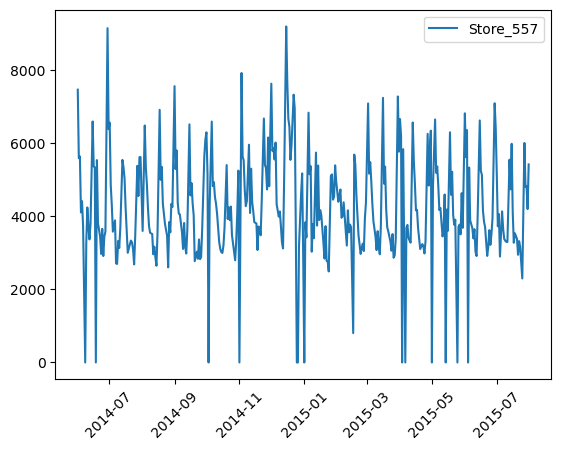

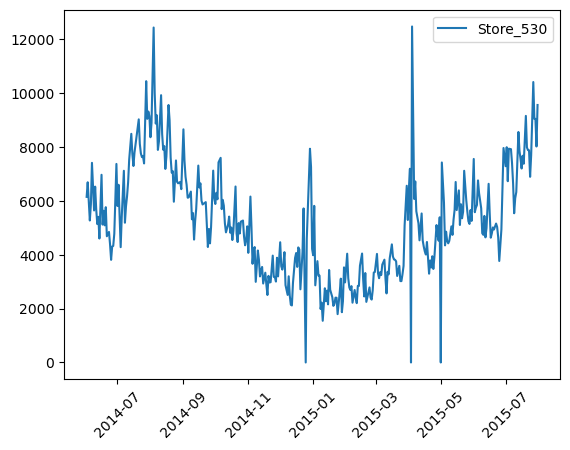

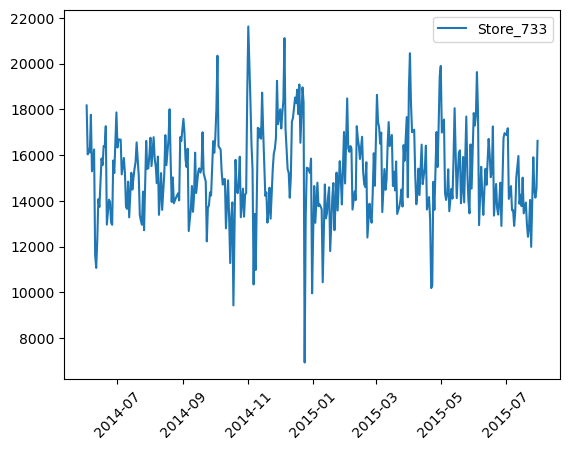

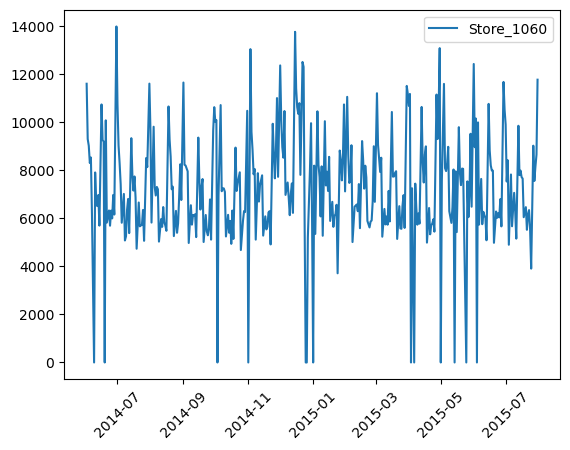

In [5]:
#pick 10 random stores and plot it's sale values after the adjustment
'''
random_values = [random.random() for _ in range(10)]

for i in range(len(random_values)):
    store = int(random_values[i]*1115)
    plot_vals = train_full_dates[train_full_dates['Store'] == store]
    plot_vals = plot_vals[plot_vals['DayOfWeek'] != 7]
    plt.plot_date(plot_vals['Date'].iloc[-365:], plot_vals['Sales'].iloc[-365:],'-',label = f'Store_{store}')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.show()

'''

In [6]:
#Adding the information from Rossmann_info to the train and test dataset
# Select the columns that are present in the Rossmann_info dataframe but not in the Rossmann_train dataframe
new_columns = set(Rossmann_info.columns) - set(train_full_dates)

# Merge the two dataframes on the "Store" column and add the new columns to the Rossmann_train dataframe
Rossmann_train = train_full_dates.merge(Rossmann_info[['Store'] + list(new_columns)], on='Store', how='left')

#repeat for the test dataframe
new_columns = set(Rossmann_info.columns) - set(Rossmann_test.columns)
Rossmann_test = Rossmann_test.merge(Rossmann_info[['Store'] + list(new_columns)], on='Store', how='left')

Rossmann_train['Date'] = pd.to_datetime(Rossmann_train['Date'])
Rossmann_train['year'] = Rossmann_train['Date'].dt.year
Rossmann_train['month'] = Rossmann_train['Date'].dt.month
Rossmann_train['day'] = Rossmann_train['Date'].dt.day
Rossmann_train['week'] = Rossmann_train['Date'].dt.week
#Rossmann_train.drop(columns='Date',inplace = True)

C:\Users\eduma\AppData\Local\Temp\ipykernel_10992\2271272900.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  Rossmann_train['week'] = Rossmann_train['Date'].dt.week


In [7]:
obj_list = ['StoreType','Assortment','StateHoliday' ]

for obj_to_hotEncoder in obj_list:
    # use pd.get_dummies() to one-hot encode the 'fruit' column
    one_hot_encoded = pd.get_dummies(Rossmann_train[obj_to_hotEncoder],prefix=obj_to_hotEncoder, prefix_sep='_')
    # concatenate the one-hot encoded DataFrame with the original DataFrame
    Rossmann_train = pd.concat([Rossmann_train, one_hot_encoded], axis=1)
    Rossmann_train = Rossmann_train.drop(columns=obj_to_hotEncoder)
    
display(Rossmann_train)
for obj_to_int in Rossmann_train.columns:
    if obj_to_int != 'PromoInterval' and obj_to_int != 'Date':
        Rossmann_train[obj_to_int] = Rossmann_train[obj_to_int].astype('float64')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionOpenSinceMonth,CompetitionDistance,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,2,2013-01-01,0,0,0,0,1,9.0,1270.0,...,0,1,0,1,0,0,0,1,0,0
1,1,3,2013-01-02,5530,668,1,0,1,9.0,1270.0,...,0,1,0,1,0,0,1,0,0,0
2,1,4,2013-01-03,4327,578,1,0,1,9.0,1270.0,...,0,1,0,1,0,0,1,0,0,0
3,1,5,2013-01-04,4486,619,1,0,1,9.0,1270.0,...,0,1,0,1,0,0,1,0,0,0
4,1,6,2013-01-05,4997,635,1,0,1,9.0,1270.0,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050325,1115,1,2015-07-27,10712,608,1,1,1,NaN,5350.0,...,0,0,1,0,0,1,1,0,0,0
1050326,1115,2,2015-07-28,8093,500,1,1,1,NaN,5350.0,...,0,0,1,0,0,1,1,0,0,0
1050327,1115,3,2015-07-29,7661,473,1,1,1,NaN,5350.0,...,0,0,1,0,0,1,1,0,0,0
1050328,1115,4,2015-07-30,8405,502,1,1,1,NaN,5350.0,...,0,0,1,0,0,1,1,0,0,0


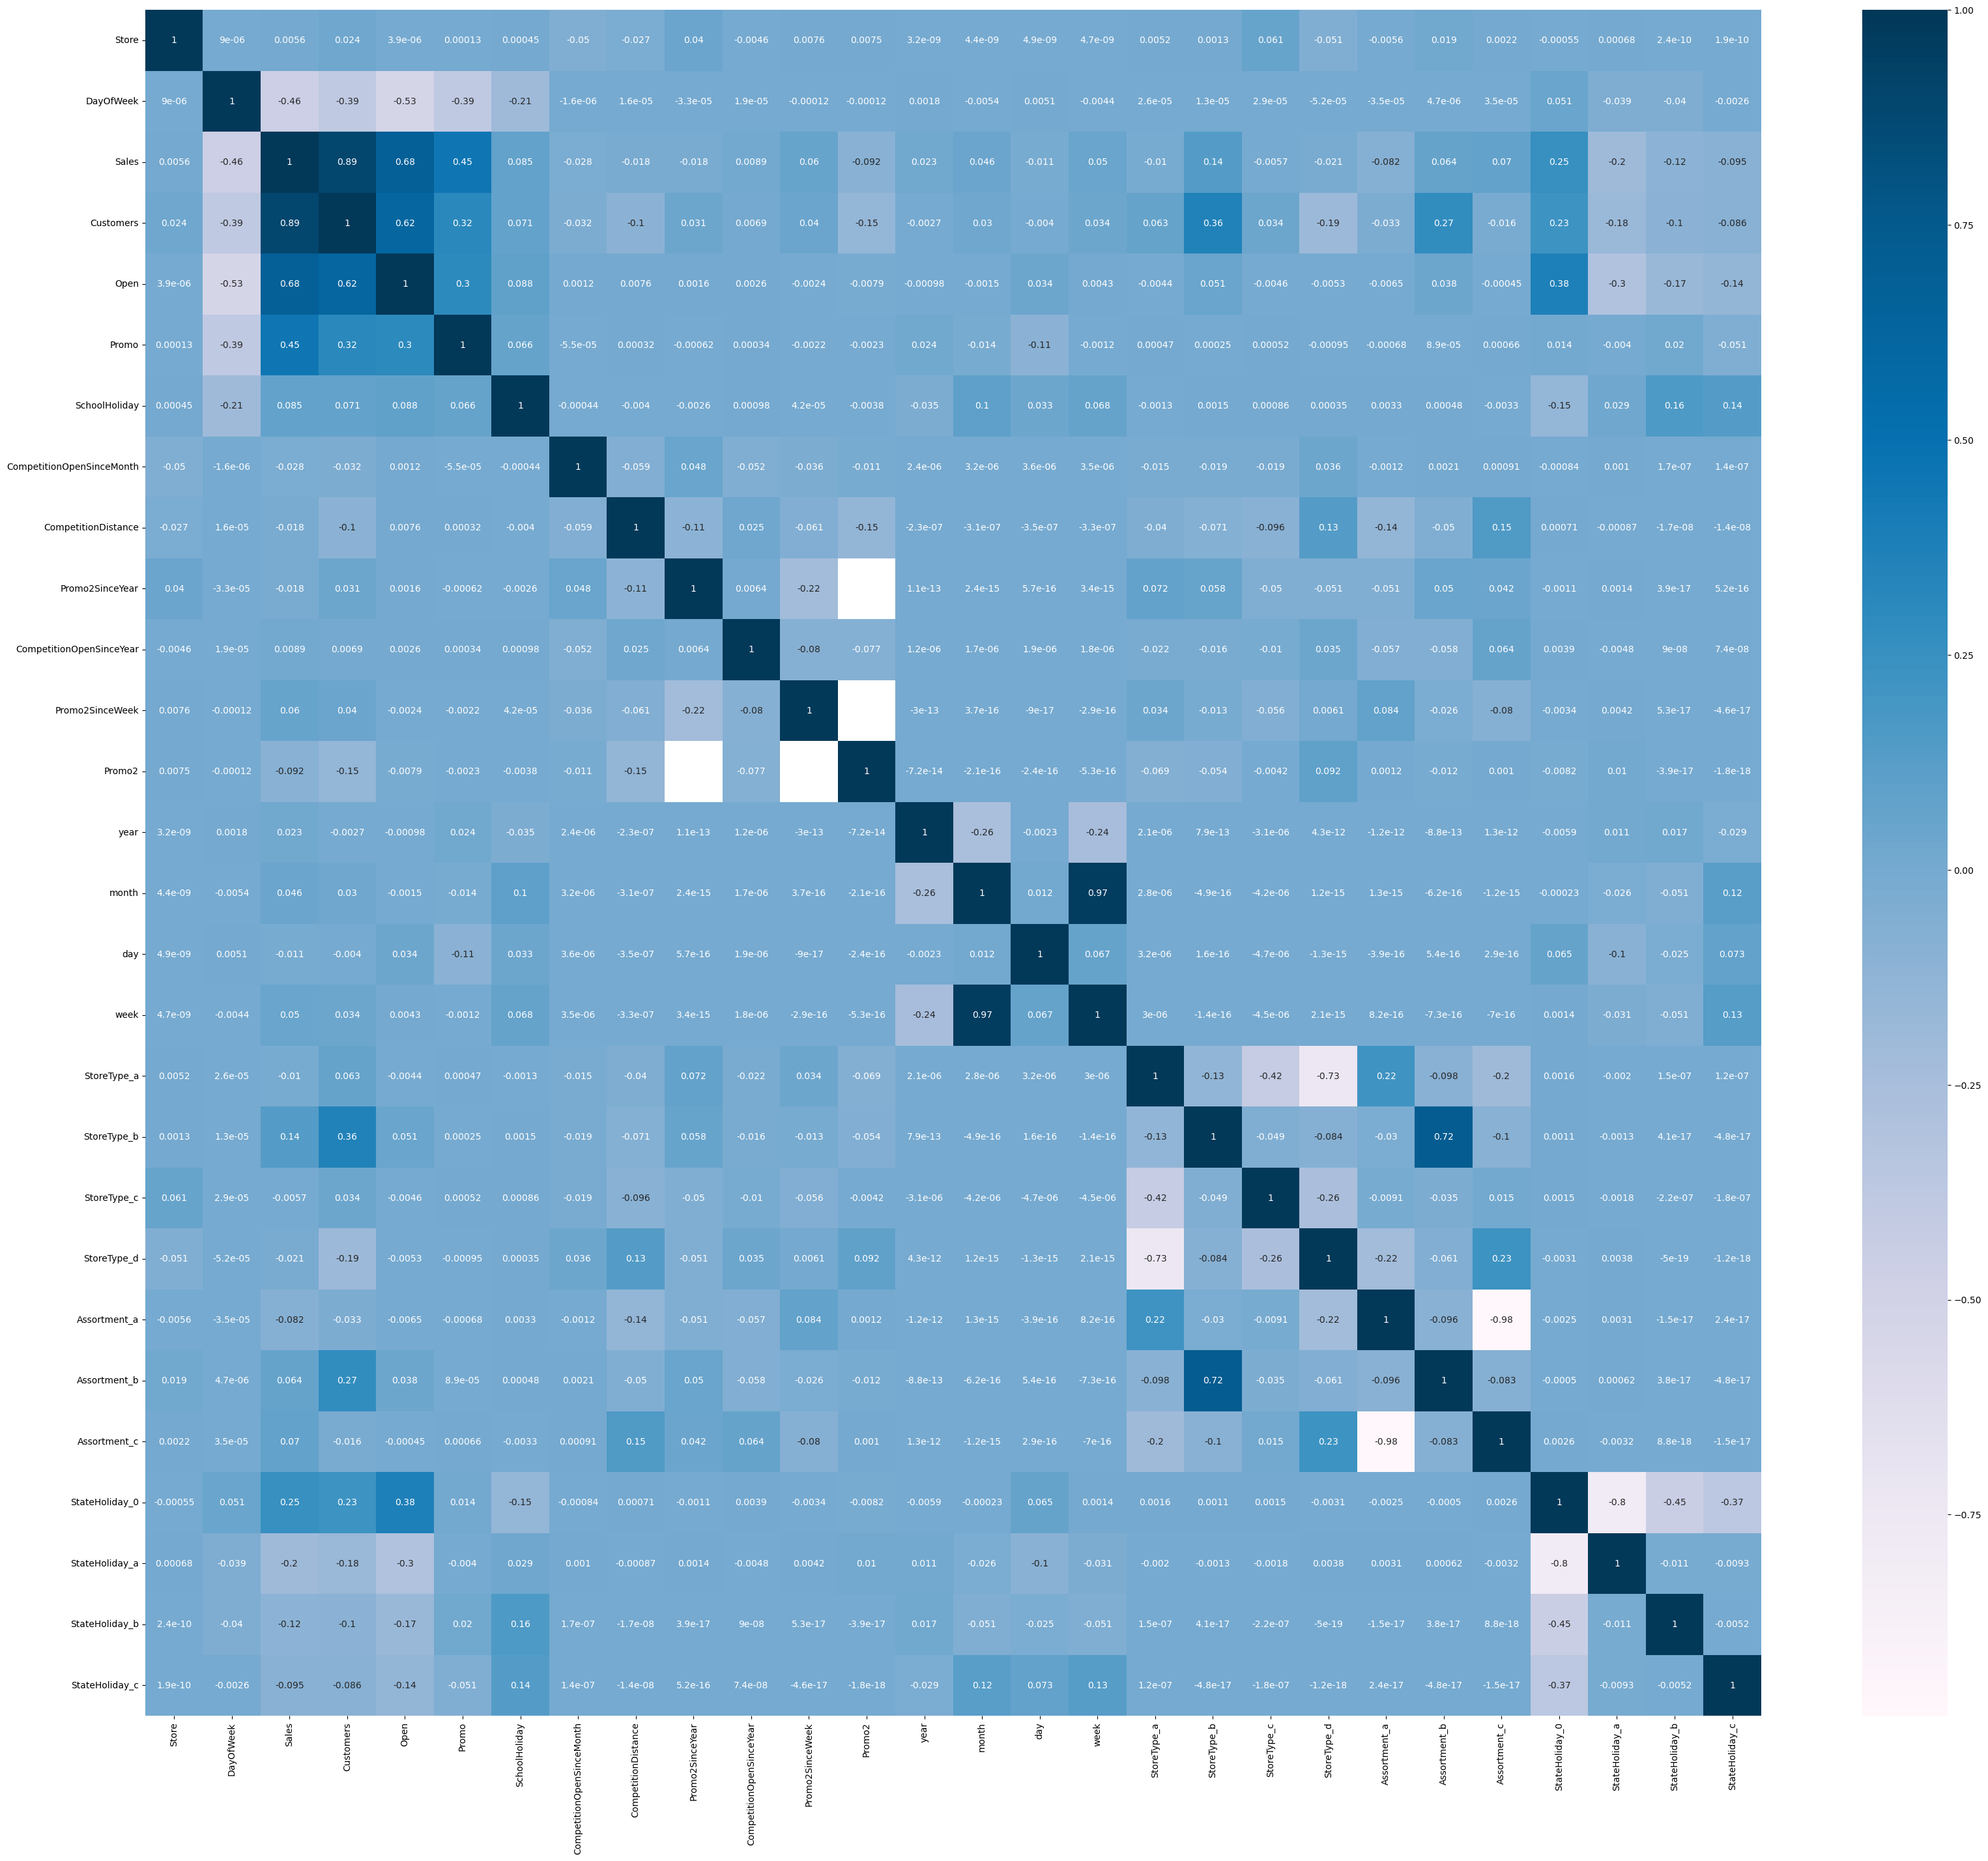

In [8]:
plt.figure(figsize = (40,34))
sns.heatmap(Rossmann_train.corr(), cmap = 'PuBu', annot = True)
plt.show()

In [9]:
for i in Rossmann_train.columns:
    if i != 'Date':
        print(i)
        print(Rossmann_train[i].unique())

Store
[1.000e+00 2.000e+00 3.000e+00 ... 1.113e+03 1.114e+03 1.115e+03]
DayOfWeek
[2. 3. 4. 5. 6. 7. 1.]
Sales
[    0.  5530.  4327. ... 26720. 25518. 27508.]
Customers
[   0.  668.  578. ... 3700. 4170. 3783.]
Open
[0. 1.]
Promo
[0. 1.]
SchoolHoliday
[1. 0.]
CompetitionOpenSinceMonth
[ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
CompetitionDistance
[1.270e+03 5.700e+02 1.413e+04 6.200e+02 2.991e+04 3.100e+02 2.400e+04
 7.520e+03 2.030e+03 3.160e+03 9.600e+02 1.070e+03 1.300e+03 4.110e+03
 3.270e+03 5.000e+01 1.384e+04 3.240e+03 2.340e+03 5.500e+02 1.040e+03
 4.060e+03 4.590e+03 4.300e+02 2.300e+03 6.000e+01 1.200e+03 2.170e+03
 4.000e+01 9.800e+03 2.910e+03 1.320e+03 2.240e+03 7.660e+03 5.400e+02
 4.230e+03 1.090e+03 2.600e+02 1.800e+02 1.180e+03 2.900e+02 4.880e+03
 9.710e+03 2.700e+02 1.060e+03 1.801e+04 6.260e+03 1.057e+04 4.500e+02
 3.036e+04 7.170e+03 7.200e+02 6.620e+03 4.200e+02 7.340e+03 2.840e+03
 5.540e+03 3.500e+02 2.050e+03 3.700e+03 2.256e+04 4.100e+02 2.500e+02
 

In [10]:
#clunky way to find out if there is a patter in number of months in PromoInterval
#num_commas = Rossmann_train['PromoInterval'].str.count(',')
#num_commas.unique()

#either empty or has 4 months on it

months_to_number = {"Jan" : 1,"Feb" : 2,"Mar" : 3,"Apr" : 4,"May" : 5,"Jun" : 6,"Jul" : 7,"Aug" : 8,
                   "Sept" : 9,"Oct" : 10,"Nov" : 11,"Dec" : 12}

Rossmann_train[['PromoInterval1', 'PromoInterval2', 'PromoInterval3','PromoInterval4']] = Rossmann_train['PromoInterval'].str.split(',', expand=True)

# Convert the month columns to numeric values
Rossmann_train['PromoInterval1'] = Rossmann_train['PromoInterval1'].map(months_to_number)
Rossmann_train['PromoInterval2'] = Rossmann_train['PromoInterval2'].map(months_to_number)
Rossmann_train['PromoInterval3'] = Rossmann_train['PromoInterval3'].map(months_to_number)
Rossmann_train['PromoInterval4'] = Rossmann_train['PromoInterval4'].map(months_to_number)


#replacing promo blocks by single values
Promo2Blocks = {1 : np.arange(1,13,3) , 2 :np.arange(2,13,3), 3: np.arange(3,13,3) }



In [11]:
Rossmann_train['Promo_2_active'] = np.where(
    ((Rossmann_train['year'] > Rossmann_train['Promo2SinceYear']) & 
     (Rossmann_train['month'] == Rossmann_train['PromoInterval1']) |
     (Rossmann_train['month'] == Rossmann_train['PromoInterval2']) |
     (Rossmann_train['month'] == Rossmann_train['PromoInterval3']) |
     (Rossmann_train['month'] == Rossmann_train['PromoInterval4'])) |
    ((Rossmann_train['year'] == Rossmann_train['Promo2SinceYear']) & 
     (Rossmann_train['month'] == Rossmann_train['PromoInterval1']) &
     (Rossmann_train['week'] >= Rossmann_train['Promo2SinceWeek'])) |
    ((Rossmann_train['year'] == Rossmann_train['Promo2SinceYear']) & 
     (Rossmann_train['month'] == Rossmann_train['PromoInterval2']) &
     (Rossmann_train['week'] >= Rossmann_train['Promo2SinceWeek'])) |
    ((Rossmann_train['year'] == Rossmann_train['Promo2SinceYear']) & 
     (Rossmann_train['month'] == Rossmann_train['PromoInterval3']) &
     (Rossmann_train['week'] >= Rossmann_train['Promo2SinceWeek'])) |
    ((Rossmann_train['year'] == Rossmann_train['Promo2SinceYear']) & 
     (Rossmann_train['month'] == Rossmann_train['PromoInterval4']) &
     (Rossmann_train['week'] >= Rossmann_train['Promo2SinceWeek'])),
    1, 0)


Rossmann_train['have_competition'] = np.zeros(len(Rossmann_train))
Rossmann_train['CompetitionOpenSinceYear'] = Rossmann_train['CompetitionOpenSinceYear'].fillna(2000)
Rossmann_train['CompetitionOpenSinceMonth'] = Rossmann_train['CompetitionOpenSinceMonth'].fillna(0)

Rossmann_train['have_competition'] = np.where(
    ((Rossmann_train['year'] > Rossmann_train['CompetitionOpenSinceYear']) |
     ((Rossmann_train['year'] == Rossmann_train['CompetitionOpenSinceYear']) & 
      (Rossmann_train['month'] >= Rossmann_train['CompetitionOpenSinceMonth']))),
    1, 0)

Rossmann_train.loc[Rossmann_train['have_competition'] == 0, 'CompetitionDistance'] = 10000
Rossmann_train.loc[Rossmann_train['CompetitionDistance'] == np.nan, 'CompetitionOpenSinceYear'] = 3000
Rossmann_train.loc[Rossmann_train['CompetitionDistance'] == 0, 'CompetitionOpenSinceMonth'] = 13


In [12]:
Rossmann_train.drop(columns =['Promo2SinceYear','Promo2SinceWeek','PromoInterval1',
                              'PromoInterval2','PromoInterval3','PromoInterval4'],inplace =True)

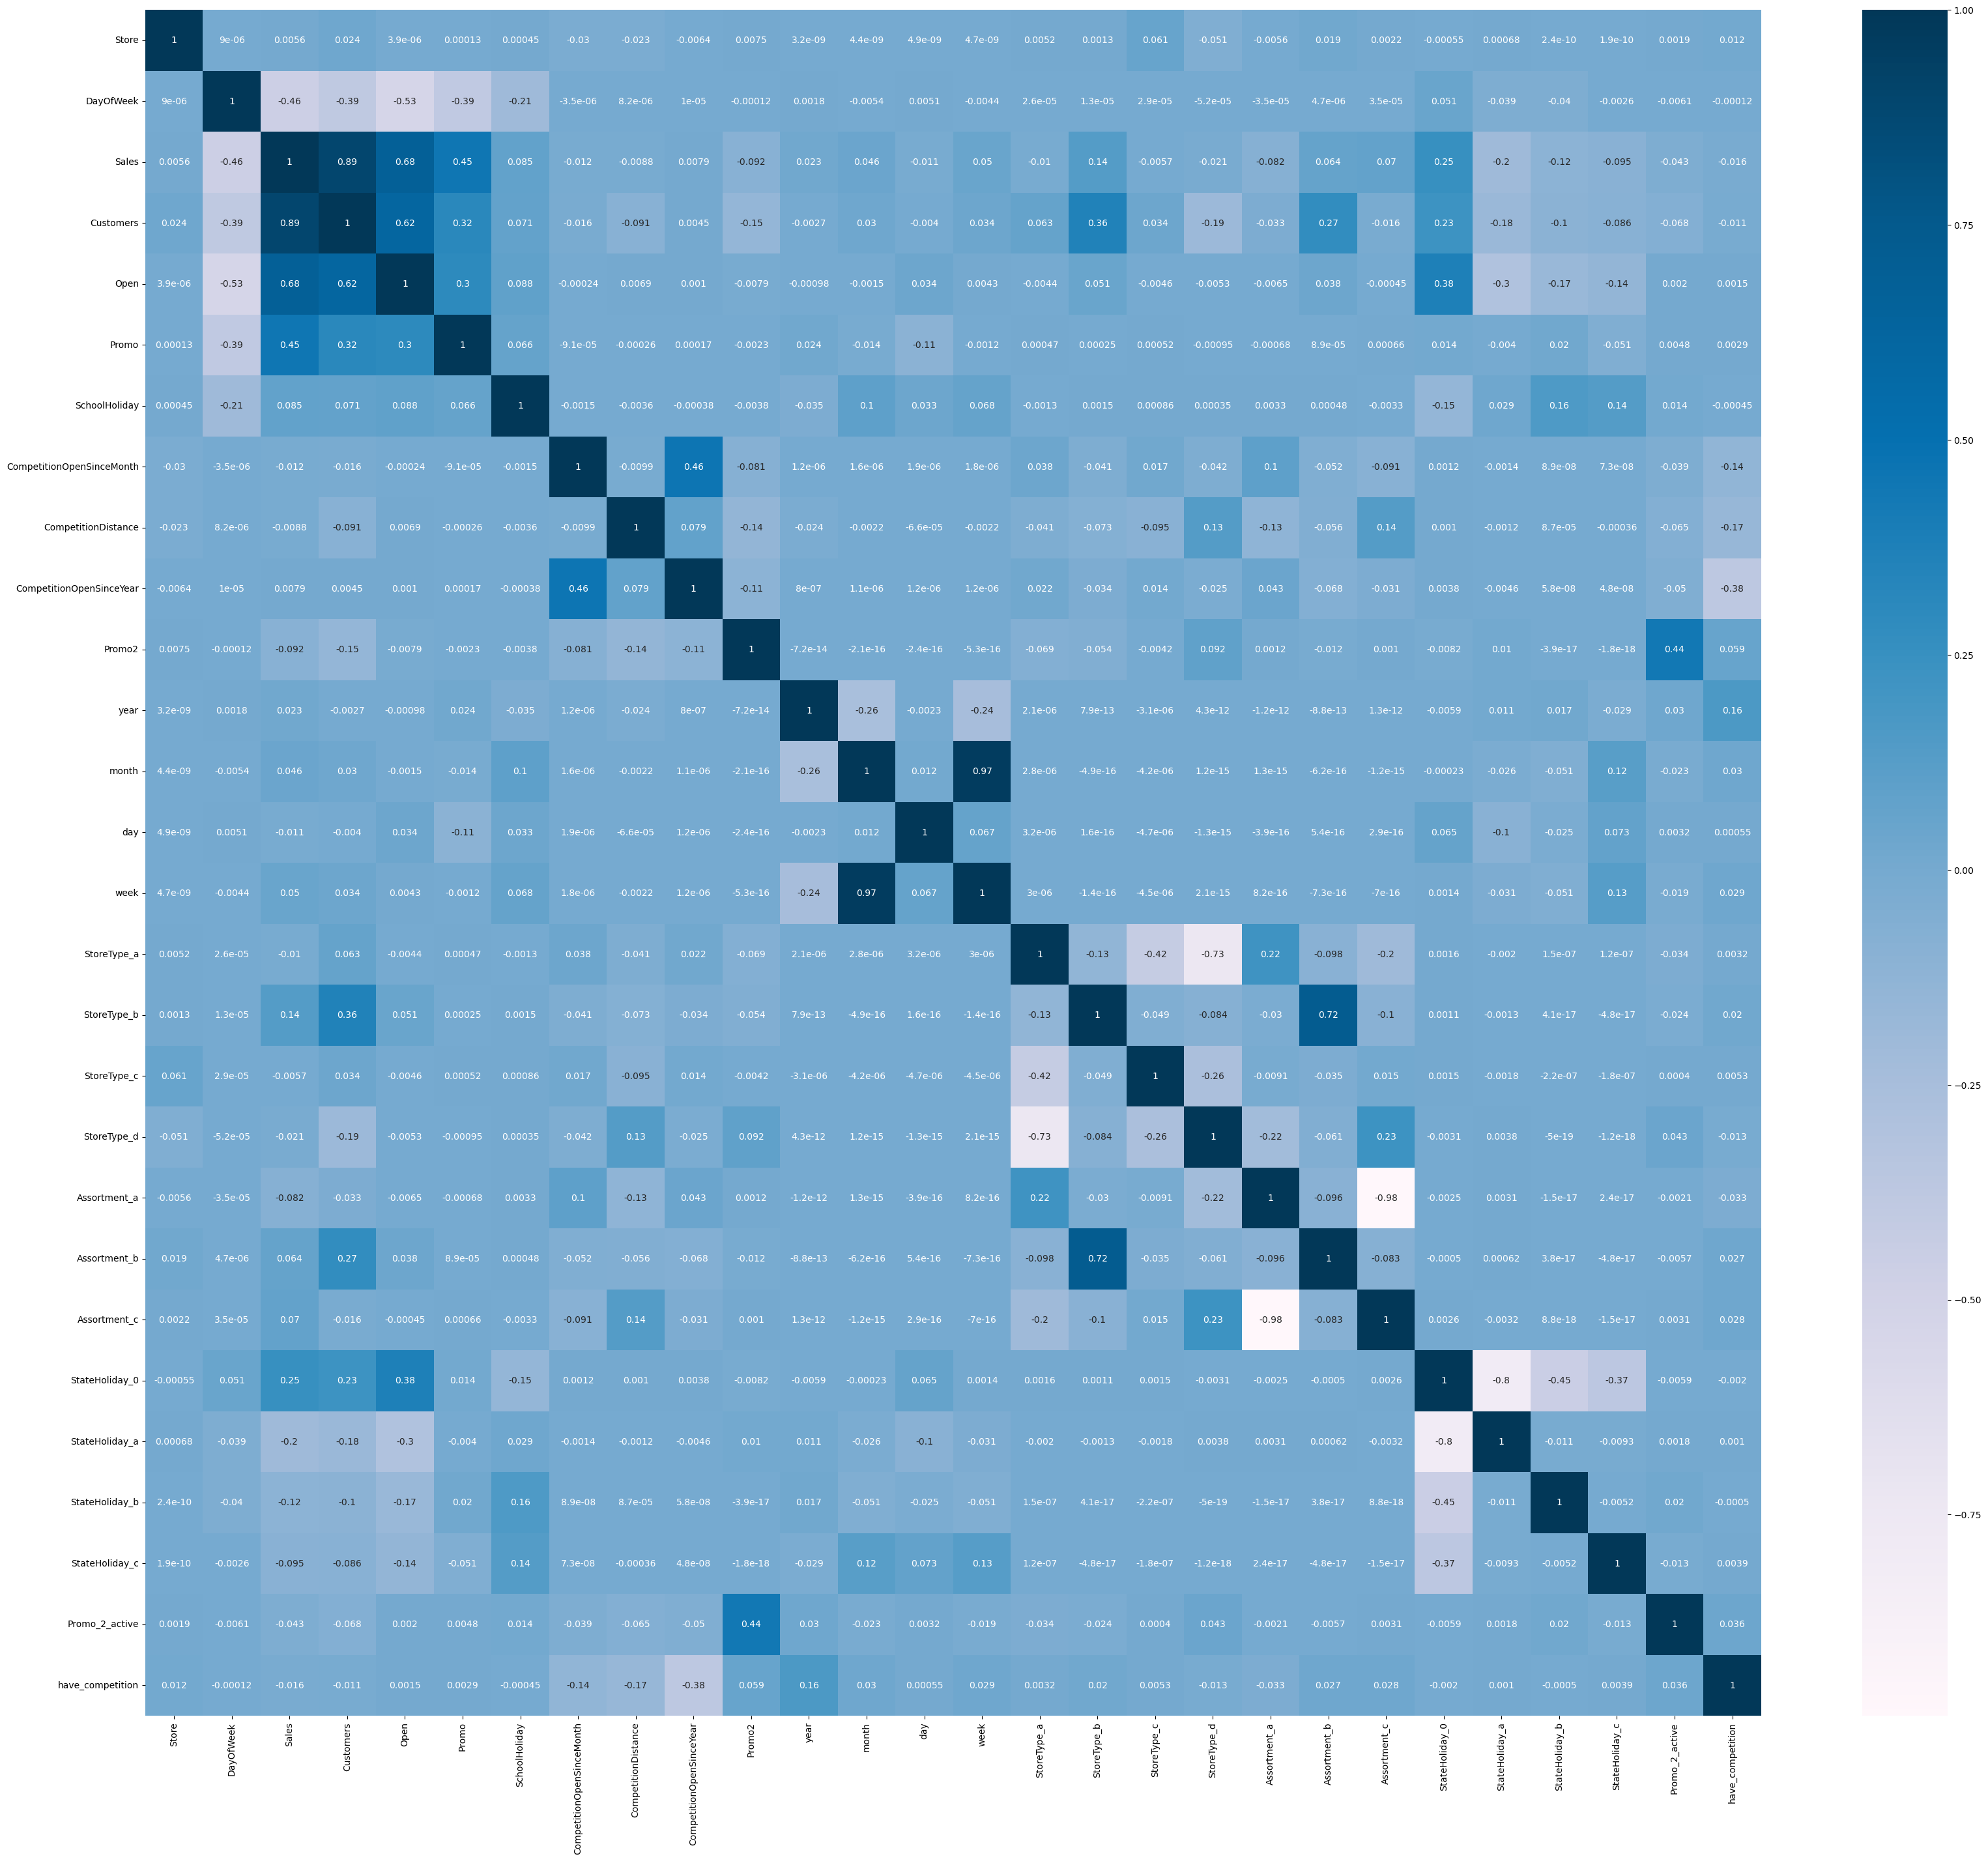

In [13]:
plt.figure(figsize = (40,34))
sns.heatmap(Rossmann_train.corr(), cmap = 'PuBu', annot = True)
plt.show()

In [14]:
Rossmann_train.to_csv('Rossmann_treated.csv', index = False)

In [15]:
Rossmann_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionOpenSinceMonth,CompetitionDistance,...,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,Promo_2_active,have_competition
0,1.0,2.0,2013-01-01,0.0,0.0,0.0,0.0,1.0,9.0,1270.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
1,1.0,3.0,2013-01-02,5530.0,668.0,1.0,0.0,1.0,9.0,1270.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
2,1.0,4.0,2013-01-03,4327.0,578.0,1.0,0.0,1.0,9.0,1270.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
3,1.0,5.0,2013-01-04,4486.0,619.0,1.0,0.0,1.0,9.0,1270.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
4,1.0,6.0,2013-01-05,4997.0,635.0,1.0,0.0,1.0,9.0,1270.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050325,1115.0,1.0,2015-07-27,10712.0,608.0,1.0,1.0,1.0,0.0,5350.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1
1050326,1115.0,2.0,2015-07-28,8093.0,500.0,1.0,1.0,1.0,0.0,5350.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1
1050327,1115.0,3.0,2015-07-29,7661.0,473.0,1.0,1.0,1.0,0.0,5350.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1
1050328,1115.0,4.0,2015-07-30,8405.0,502.0,1.0,1.0,1.0,0.0,5350.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1
